This notebook provides a procedure to compute the deformation of a bond. 

Comentaris. La referència de l'energia, estrictament parlant, hauria de ser l'energia dels fragments. Això no es té en compte. Es pot fixar la referència d'energia en la conformació més estable, igual que en els dihedres o els angles. 

In [1]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase.visualize import view
from ase.io import trajectory
from ase import build
from ase.data.pubchem import pubchem_atoms_search

In [2]:
def evaluate_bond(molecule, bond_ids, mask,  calculator_list, search_space=None , resolution=None, mol_name='', visualize=True):
    '''
    Definition
    ----------
    Evaluates the PES of the breaking of a bond.
    bond_ids contain the index of the atoms that form the bond. 
    '''


    # create the working directory
    work_dir = os.path.join(os.curdir, mol_name)
    if not os.path.isdir(work_dir):
        os.makedirs(work_dir)

    # define scan space and resolution
    if resolution is None:
        resolution = 100
    if search_space is None:
        search_space = [1.0, 6.0]
    dist_list = np.linspace(search_space[0], search_space[1], resolution)
    
    # create a trajectory file for the scan (one calculator only)
    if len(calculator_list) == 1:
        traj_path = os.path.join(work_dir, 'bond_scan.traj')
        traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')


    # compute the distances
    print(f'computing {molecule[bond_ids[0]].symbol}{molecule[bond_ids[0]].index}-{molecule[bond_ids[1]].symbol}{molecule[bond_ids[1]].index} PES\nscan range {search_space} Å')
    print(f'evaluating {len(dist_list)} distances')
    print(f'distances:\n{dist_list}\n')

    # save energies
    energies = []

    # evaluate each calculator
    for calc_ in calculator_list: 

        calc_energy_list = []

        for d in dist_list:

            # define the configuration
            molecule.set_distance(bond_ids[0], bond_ids[1], d, mask=mask, fix=0)
            molecule.calc = calc_
            potential_e = molecule.get_potential_energy()
            calc_energy_list.append(potential_e)
        
            if len(calculator_list) == 1:
                traj.write(molecule)

        # compute reference
        # TODO

        energies.append(calc_energy_list)

        if len(calculator_list) == 1:
            traj.close()

    if visualize:
        if len(calculator_list) == 1:
            traj = trajectory.TrajectoryReader(os.path.join('./', mol_name, 'bond_scan.traj'))
            view(traj, viewer='ase')

    return dist_list, energies



def plot_bond(distance_list, energy_list, calculator_names, calculator_colors, mol_name='', calc_name='', bond_name=''):
    '''
    Plot a bond scan. 
    '''

    work_dir = os.path.join(os.curdir, mol_name)

    _color_list = ['black', 'red', 'orange', 'blue']
    _marker_list = ['^', 'd', 'v', 'o']

    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6,4)) 
    axes.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(calculator_names)):
        
        # gather the minimum energy structure
        idx = np.argmin(energy_list[k][:])
        min_energy = energy_list[k][idx]
        min_dih = distance_list[idx]

        # TODO convert energy from eV/particle to kcal/mol: 1 eV/molecule = 23.0605 kcal/mol

        axes.plot(distance_list, (np.array(energy_list[k][:])-min_energy), label=r'$\textnormal{' + calculator_names[k] + r'}$', color=calculator_colors[k], alpha=0.9)
        axes.scatter(min_dih, min_energy-min_energy, color=_color_list[k], marker=_marker_list[k], label=r'$\textnormal{energy ref @ ' + f'{min_dih:.3f}' + r' Å}$')

    axes.set(xlabel=r'$\textnormal{' + f'{mol_name} {bond_name}' + r' bond distance}\;\textnormal{(Å)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$')
    axes.legend(loc='best', title=f'{mol_name}', title_fontsize='large')

    plt.tight_layout()
    plt.savefig(os.path.join(work_dir, f'{mol_name}_{bond_name}_bond_{calc_name}'+'_PES.png'), dpi=300)
    plt.show(fig)

In [2]:
#=======================#
#       CALCULATOR      #
#=======================#

from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float64", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float64'
    )

calculator_list = [macemp, maceoff]
calculator_names = ['MACE-MP', 'MACE-OFF']
calculator_colors = ['deeppink', 'darkgreen']

calculator_list = [maceoff]
calculator_names = ['MACE-OFF']

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


In [5]:
#======================#
#       TEST ZONE      #
#======================#

# define the molecule
mol_name = 'ethanol'
molecule = build.molecule('CH3CH2OH')

# select the C-C bond and provide the mask
for atom in molecule:
    print(atom.index, atom.symbol)
#view(molecule, viewer='ase')

bond_name = 'CO'
bond_ids = [1, 2]
mask = [0, 0, 1, 1, 0, 0, 0, 0, 0]

# evaluate the conformations
molecule.set_distance(bond_ids[0], bond_ids[1], 3., mask=mask)
#view(molecule, viewer='ase')

0 C
1 C
2 O
3 H
4 H
5 H
6 H
7 H
8 H


## __EXAMPLES__

In [2]:
from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float64", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float64'
    )

calculator_list = [macemp, maceoff]
calculator_names = ['MACE-MP', 'MACE-OFF']
calculator_colors = ['darkgreen', 'deeppink']
CALC_NAME = 'MACE'

#calculator_list = [macemp]
#calculator_names = ['MACE-MP']

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


In [2]:
# torchani
from torchani.models import ANI1x, ANI1ccx, ANI2x

# define calculators
ani1x_calc = ANI1x().ase()
ani1ccx_calc = ANI1ccx().ase()
ani2x_calc = ANI2x().ase()

calculator_list = [ani1x_calc, ani2x_calc]
calculator_names = ['ANI-1x', 'ANI-2x']
calculator_colors = ['darkgreen', 'deeppink']

#calculator_list = [ani2x_calc]
#calculator_names = ['ANI-2x']

CALC_NAME = 'ANI'

/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/


In [2]:
# calculator 
from orb_models.forcefield.pretrained import orb_v2, orb_d3_v2
from orb_models.forcefield.calculator import ORBCalculator

orbff_v2 = orb_v2(device='cpu')
orb_calc_v2 = ORBCalculator(orbff_v2, device='cpu')

orbff_d3_v2 = orb_d3_v2(device='cpu')
orb_calc_d3_v2 = ORBCalculator(orbff_d3_v2, device='cpu')

# define the calculators
calculator_list = [orb_calc_v2, orb_calc_d3_v2]
calculator_names = ['ORB-V2', 'ORB-D3-V2']
calculator_colors = ['deeppink', 'darkgreen']

CALC_NAME = 'ORB'

computing C0-C1 PES
scan range [1.0, 7.0] Å
evaluating 40 distances
distances:
[1.         1.15384615 1.30769231 1.46153846 1.61538462 1.76923077
 1.92307692 2.07692308 2.23076923 2.38461538 2.53846154 2.69230769
 2.84615385 3.         3.15384615 3.30769231 3.46153846 3.61538462
 3.76923077 3.92307692 4.07692308 4.23076923 4.38461538 4.53846154
 4.69230769 4.84615385 5.         5.15384615 5.30769231 5.46153846
 5.61538462 5.76923077 5.92307692 6.07692308 6.23076923 6.38461538
 6.53846154 6.69230769 6.84615385 7.        ]



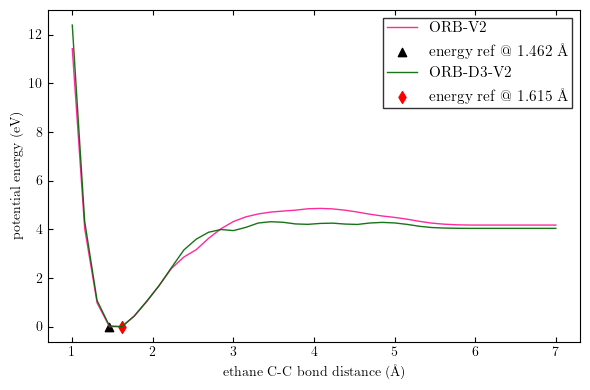

In [4]:
# define the molecule
mol_name = 'ethane'
ethane = build.molecule('C2H6')

# parameters

bond_name = 'C-C'
bond_ids = [0, 1]
mask = [0, 1, 0, 0, 0, 1, 1, 1]

# perform the scan
distances, energies = evaluate_bond(ethane, bond_ids, mask,  calculator_list, search_space=[1.0, 7.0], resolution=40, mol_name=mol_name, visualize=True)
plot_bond(distances, energies, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name)

computing C1-H2 PES
scan range [1.0, 15.0] Å
evaluating 200 distances
distances:
[ 1.          1.07035176  1.14070352  1.21105528  1.28140704  1.35175879
  1.42211055  1.49246231  1.56281407  1.63316583  1.70351759  1.77386935
  1.84422111  1.91457286  1.98492462  2.05527638  2.12562814  2.1959799
  2.26633166  2.33668342  2.40703518  2.47738693  2.54773869  2.61809045
  2.68844221  2.75879397  2.82914573  2.89949749  2.96984925  3.04020101
  3.11055276  3.18090452  3.25125628  3.32160804  3.3919598   3.46231156
  3.53266332  3.60301508  3.67336683  3.74371859  3.81407035  3.88442211
  3.95477387  4.02512563  4.09547739  4.16582915  4.2361809   4.30653266
  4.37688442  4.44723618  4.51758794  4.5879397   4.65829146  4.72864322
  4.79899497  4.86934673  4.93969849  5.01005025  5.08040201  5.15075377
  5.22110553  5.29145729  5.36180905  5.4321608   5.50251256  5.57286432
  5.64321608  5.71356784  5.7839196   5.85427136  5.92462312  5.99497487
  6.06532663  6.13567839  6.20603015  6.2763

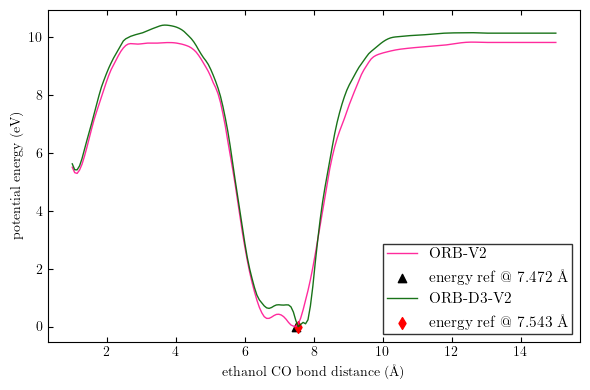

In [5]:
# define the molecule
mol_name = 'ethanol'
molecule = build.molecule('CH3CH2OH')

bond_name = 'CO'
bond_ids = [1, 2]
mask = [0, 0, 1, 1, 0, 0, 0, 0, 0]

# perform the scan
distances, energies = evaluate_bond(ethane, bond_ids, mask,  calculator_list, search_space=[1.0, 15.0], resolution=200, mol_name=mol_name, visualize=True)
plot_bond(distances, energies, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name)

## __CYCLOBUTADIENE__
Assess the assymetry knowledge of the system

In [3]:
# define the molecule
mol_name = 'cylobutadiene'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')

# select the C-C bond and provide the mask

for atom in molecule:
    print(atom.index, atom.symbol)
#view(molecule, viewer='ase')


# hortitzontal
# C: 0 2, H: 4 6, distancia curta amb C: 1 3, H: 5 7 
# [0, 1], [2, 3], [4, 5], [6, 7]
bond_ids_h = [0, 1]
mask_h = [0, 1, 0, 1, 0, 1, 0, 1]

# vertical 
# C: 0 1, H: 4 5, distancia llarga amb C: 2 3, H: 6 7  
bond_ids_v = [0, 2]
mask_v = [0, 0, 1, 1, 0, 0, 1, 1]

mol_name = 'cylobutadiene'
bond_name = 'CC'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')

# set C-C distances
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)

# set C-H distances
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

view(molecule, viewer='ase')

0 C
1 C
2 C
3 C
4 H
5 H
6 H
7 H


<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

computing C0-C2 PES
scan range [1.2, 1.8] Å
evaluating 100 distances
distances:
[1.2        1.20606061 1.21212121 1.21818182 1.22424242 1.23030303
 1.23636364 1.24242424 1.24848485 1.25454545 1.26060606 1.26666667
 1.27272727 1.27878788 1.28484848 1.29090909 1.2969697  1.3030303
 1.30909091 1.31515152 1.32121212 1.32727273 1.33333333 1.33939394
 1.34545455 1.35151515 1.35757576 1.36363636 1.36969697 1.37575758
 1.38181818 1.38787879 1.39393939 1.4        1.40606061 1.41212121
 1.41818182 1.42424242 1.43030303 1.43636364 1.44242424 1.44848485
 1.45454545 1.46060606 1.46666667 1.47272727 1.47878788 1.48484848
 1.49090909 1.4969697  1.5030303  1.50909091 1.51515152 1.52121212
 1.52727273 1.53333333 1.53939394 1.54545455 1.55151515 1.55757576
 1.56363636 1.56969697 1.57575758 1.58181818 1.58787879 1.59393939
 1.6        1.60606061 1.61212121 1.61818182 1.62424242 1.63030303
 1.63636364 1.64242424 1.64848485 1.65454545 1.66060606 1.66666667
 1.67272727 1.67878788 1.68484848 1.69090909 1.696

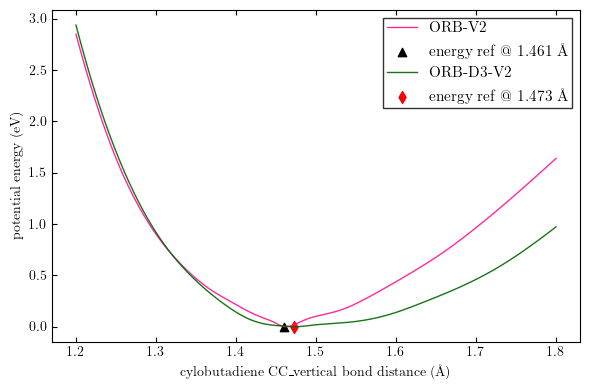

In [7]:
# deformació vertical
# define square
mol_name = 'cylobutadiene'
bond_name = 'CC'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)
#view(molecule)

distances_v, energies_v = evaluate_bond(molecule, bond_ids_v, mask_v,  calculator_list, search_space=[1.2, 1.8], resolution=100, mol_name=mol_name, visualize=True)
plot_bond(distances_v, energies_v, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name+'_vertical')

computing C0-C1 PES
scan range [1.2, 1.8] Å
evaluating 100 distances
distances:
[1.2        1.20606061 1.21212121 1.21818182 1.22424242 1.23030303
 1.23636364 1.24242424 1.24848485 1.25454545 1.26060606 1.26666667
 1.27272727 1.27878788 1.28484848 1.29090909 1.2969697  1.3030303
 1.30909091 1.31515152 1.32121212 1.32727273 1.33333333 1.33939394
 1.34545455 1.35151515 1.35757576 1.36363636 1.36969697 1.37575758
 1.38181818 1.38787879 1.39393939 1.4        1.40606061 1.41212121
 1.41818182 1.42424242 1.43030303 1.43636364 1.44242424 1.44848485
 1.45454545 1.46060606 1.46666667 1.47272727 1.47878788 1.48484848
 1.49090909 1.4969697  1.5030303  1.50909091 1.51515152 1.52121212
 1.52727273 1.53333333 1.53939394 1.54545455 1.55151515 1.55757576
 1.56363636 1.56969697 1.57575758 1.58181818 1.58787879 1.59393939
 1.6        1.60606061 1.61212121 1.61818182 1.62424242 1.63030303
 1.63636364 1.64242424 1.64848485 1.65454545 1.66060606 1.66666667
 1.67272727 1.67878788 1.68484848 1.69090909 1.696

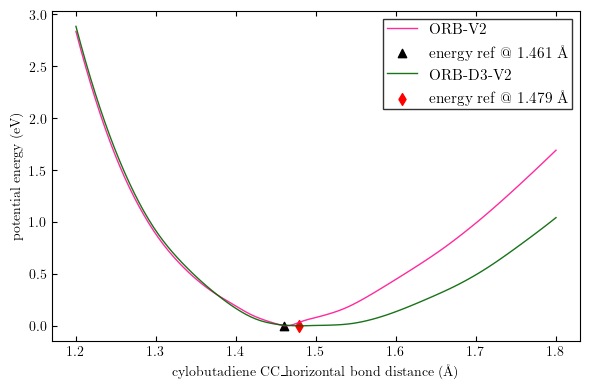

In [8]:
# deformació horitzontal
mol_name = 'cylobutadiene'
bond_name = 'CC'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)
#view(molecule)

# deformació hortiztonal
distances_h, energies_h = evaluate_bond(molecule, bond_ids_h, mask_h,  calculator_list, search_space=[1.2, 1.8], resolution=100, mol_name=mol_name, visualize=True)
plot_bond(distances_h, energies_h, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name+'_horizontal')

In [4]:
# calculator for this 2D PES scan
CALCULATOR = orb_calc_d3_v2
CALCULATOR_NAME = 'ORB-D3-v2'


energy_matrix = []

# initial square geometry
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

work_dir = os.path.join(os.curdir, mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

for d_x in distances_h:

    temp_list = []

    for d_y in distances_v:
        molecule.set_distance(bond_ids_h[0], bond_ids_h[1], d_x, fix=0, mask=mask_h)
        molecule.set_distance(bond_ids_v[0], bond_ids_v[1], d_y, fix=0, mask=mask_v)

        molecule.calc = CALCULATOR
        potential_e = molecule.get_potential_energy()
        temp_list.append(potential_e)

        traj.write(molecule)

    energy_matrix.append(temp_list)

NameError: name 'orb_calc_d3_v2' is not defined

In [14]:
corrected_energy_matrix = np.array(energy_matrix) - np.min(np.array(energy_matrix))

In [ ]:
work_dir = os.path.join(os.curdir, mol_name)
traj_path = os.path.join(work_dir, 'bond_scan.traj')
#traj_path = os.path.join(work_dir, 'bond_scan_2D_ORB-D3-V2_QUESTIONABLE.traj')
traj = trajectory.TrajectoryReader(traj_path)
view(traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/env

1.3459001523144276 1.4292001819199438


/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_42267/3454677034.py:13: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_42267/3454677034.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


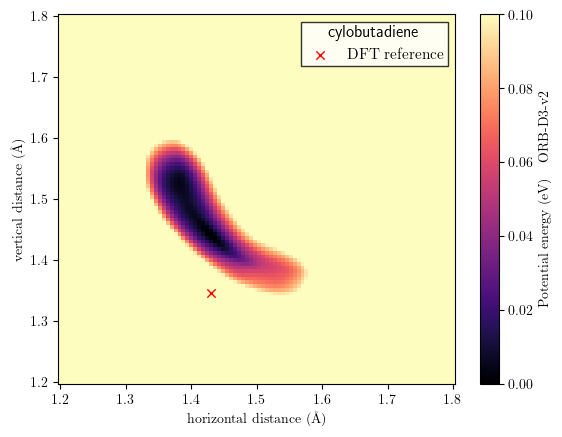

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/env

In [16]:
# default distances
ref_molecule = pubchem_atoms_search(smiles='C1=CC=C1')

vertical = ref_molecule.get_distance(0, 1)
horzontal = ref_molecule.get_distance(0, 2)
print(vertical, horzontal)

fig, ax = plt.subplots()
im = ax.pcolormesh(distances_h, distances_v, corrected_energy_matrix, vmax=0.1, cmap='magma', label=r'$\textnormal{}$')
ax.scatter(horzontal, vertical, color='red', marker='x', label=r'$\textnormal{DFT reference}$')
ax.set(xlabel=r'$\textnormal{horizontal distance (Å)}$', ylabel=r'$\textnormal{vertical distance (Å)}$')

ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
fig.colorbar(im, ax=ax, label=r'$\textnormal{Potential energy (eV)}\quad\textnormal{'+f'{CALCULATOR_NAME}'+r'}$')
fig.savefig(os.path.join(work_dir, f'{mol_name}_{CALCULATOR_NAME}'+'_2D_PES.png'), dpi=400)
fig.show()

Aquest és un exemple on el model prediu correctament les asimetries del sistema. Existeixen certes molècules on el trencament de la simetria pot ser beneficiós trencant certes degeneracions i estabilitzant el sistema. Second order Jean Teller effect. 

Es comprova que tots els models són simètrics excepte en el cas del ORB-V2-D3... investiguem

In [9]:
def evaluate_rotation(molecule, calculator_list, mol_name, calc_name, verbose=False, rot_angle='z'):

    work_dir = os.path.join(os.path.curdir, mol_name)

    # fixed resolution 
    delta_angle = 5.
    points = int(360./delta_angle)
    angles = np.linspace(0., 360., points+1)
    print(f'analyzing {points} rotationally different structures')
    print(f'using {len(calculator_list)} models')
    print(f'scanning angles:\n{angles}')
    
    energies = []
    forces = []

    for calc_ in calculator_list:

        molecule.calc = calc_
        calc_energy_list = []
        calc_force_list = []

        for angle in angles:
            
            energy_ = molecule.get_potential_energy()
            force = np.array(molecule.get_forces())
            f_vec = force.sum(axis=0)
            f_scalar = np.sqrt(f_vec.dot(f_vec))

            calc_energy_list.append(energy_)
            calc_force_list .append(f_scalar)
            
            if verbose:
                print(f'energy ({angle:.0f} deg)\t{energy_}')
            
            molecule.rotate(delta_angle, rot_angle)
        
        energies.append(calc_energy_list)
        forces.append(calc_force_list)

    print(f'resulting energies:\n{energies}')
    print(f'resulting forces (total, scalar):\n{force}')

    # plot the energies
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
    ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(calculator_list)):
        idx = np.argmin(energies[k][:])
        min_energy = energies[k][idx]
        ax.plot(angles, (np.array(energies[k][:])-min_energy), label=r'$\textnormal{' + calculator_names[k] + r'}$', color=calculator_colors[k], alpha=0.9)

    #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
    ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\Delta E\quad\textnormal{(eV)}$')
    # workaround only to avoid displaying very small numbers (truncation errors)
    #ax.set_ylim(-1e-5, 1e-5)
    ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
    
    plt.tight_layout()
    plt.savefig(f'{mol_name}_{calc_name}_rotation', dpi=300)
    # no va ns pq: plt.savefig(os.path.join(work_dir, f'{mol_name}_{calc_name}_rotation'), dpi=300)
    plt.show(fig)


    # plot the forces
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
    ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(calculator_list)):
        idx = np.argmin(forces[k][:])
        min_energy = forces[k][idx]
        ax.plot(angles, (np.array(forces[k][:])-min_energy), label=r'$\textnormal{' + calculator_names[k] + r'}$', color=calculator_colors[k], alpha=0.9)

    #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
    ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\textnormal{Total forces}\quad\textnormal{(eV/Å)}$')
    # workaround only to avoid displaying very small numbers (truncation errors)
    #ax.set_ylim(-1e-5, 1e-5)
    ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
    
    plt.tight_layout()
    plt.savefig(f'{mol_name}_{calc_name}_rotation_forces', dpi=300)
    # no va ns pq: plt.savefig(os.path.join(work_dir, f'{mol_name}_{calc_name}_rotation'), dpi=300)
    plt.show(fig)

analyzing 72 rotationally different structures
using 2 models
scanning angles:
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360.]
resulting energies:
[[-46.20231246948242, -46.20213317871094, -46.204830169677734, -46.2092399597168, -46.214969635009766, -46.21836471557617, -46.21916961669922, -46.220603942871094, -46.220420837402344, -46.22038269042969, -46.22057342529297, -46.22003936767578, -46.21915817260742, -46.22012710571289, -46.221900939941406, -46.22211837768555, -46.218994140625, -46.21597671508789, -46.21490478515625, -46.21226501464844, -46.20919418334961, -46.207393646240234, -46.2081184387207, -46.21038055419922, -46.2117805480957, -46.210487365722656, -46.2

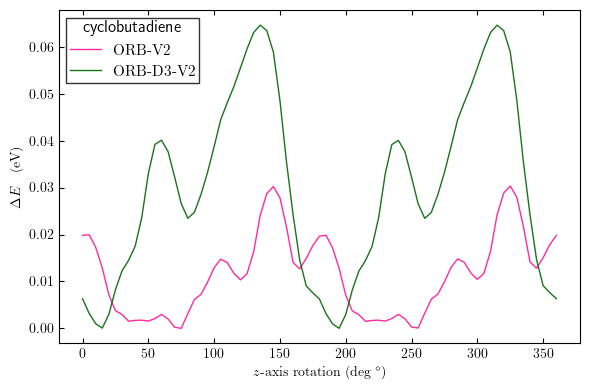

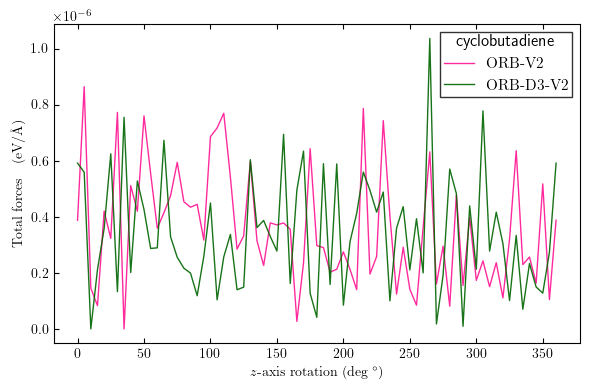

In [10]:
mol_name = 'cyclobutadiene'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.700000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)


evaluate_rotation(molecule, calculator_list, calc_name=CALC_NAME, mol_name=mol_name)

# proves bàsiques amb el cyclobutadie, efectivament no quadra
#print(f'energy (long vertical)\t{molecule.get_potential_energy()}')
#view(molecule, viewer='ase')
#print(f'energy (long horizontal)\t{molecule.get_potential_energy()}')
#view(molecule, viewer='ase')

El que jo havia vist al plot era una diferència de 0.04 eV, consistent amb el que em diu el gràfic. Amb la 2D PES del orb sense 3D corrections no havia vist això!

Ara comprovem l'aigua

analyzing 72 rotationally different structures
using 2 models
scanning angles:
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360.]
resulting energies:
[[-14.103484153747559, -14.103280067443848, -14.103404998779297, -14.103487968444824, -14.103361129760742, -14.103442192077637, -14.104279518127441, -14.105541229248047, -14.106494903564453, -14.106771469116211, -14.10676097869873, -14.106782913208008, -14.106647491455078, -14.106801986694336, -14.107446670532227, -14.107818603515625, -14.108013153076172, -14.108760833740234, -14.110395431518555, -14.111873626708984, -14.11256217956543, -14.112665176391602, -14.112524032592773, -14.112024307250977, -14.111529350280762, -14.

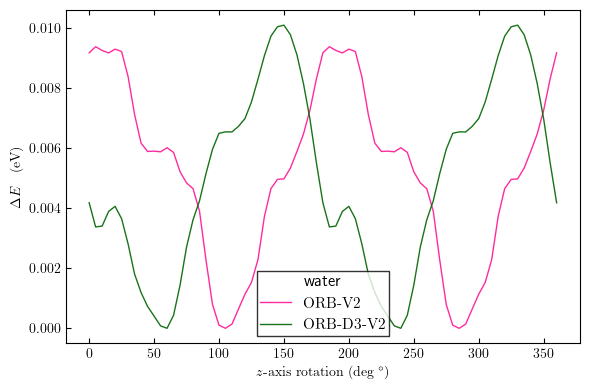

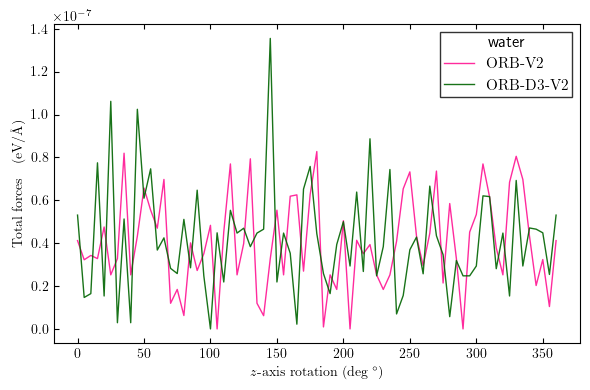

In [11]:
mol_name = 'water'
molecule = build.molecule('H2O')

evaluate_rotation(molecule, calculator_list, calc_name=CALC_NAME, mol_name=mol_name)

analyzing 72 rotationally different structures
using 2 models
scanning angles:
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360.]
resulting energies:
[[-76.15709686279297, -76.1549072265625, -76.153564453125, -76.1528549194336, -76.15228271484375, -76.15278625488281, -76.15496826171875, -76.15796661376953, -76.1605224609375, -76.16144561767578, -76.160400390625, -76.15888977050781, -76.15709686279297, -76.1549072265625, -76.15355682373047, -76.15286254882812, -76.15228271484375, -76.15277862548828, -76.15496826171875, -76.15796661376953, -76.1605224609375, -76.16144561767578, -76.160400390625, -76.15888977050781, -76.15709686279297, -76.1549072265625, -76.153564453125, -

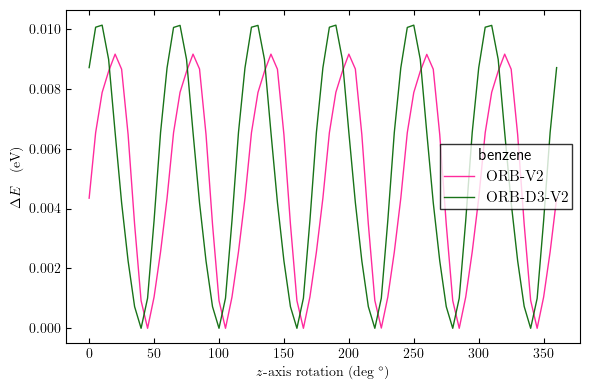

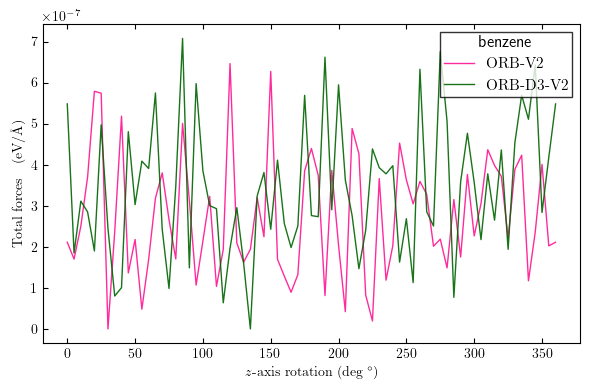

In [12]:
mol_name = 'benzene'
molecule = build.molecule('C6H6')

evaluate_rotation(molecule, calculator_list, calc_name=CALC_NAME, mol_name=mol_name)

analyzing 72 rotationally different structures
using 2 models
scanning angles:
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360.]
resulting energies:
[[-46.83313751220703, -46.8309326171875, -46.82970428466797, -46.82939910888672, -46.829681396484375, -46.82999801635742, -46.83082580566406, -46.83261489868164, -46.8352165222168, -46.83698272705078, -46.83775329589844, -46.83747482299805, -46.83635330200195, -46.8342399597168, -46.83127975463867, -46.828372955322266, -46.82666778564453, -46.82595443725586, -46.8245849609375, -46.822731018066406, -46.82097625732422, -46.818992614746094, -46.818504333496094, -46.818565368652344, -46.8194465637207, -46.82164001464844, -46.82

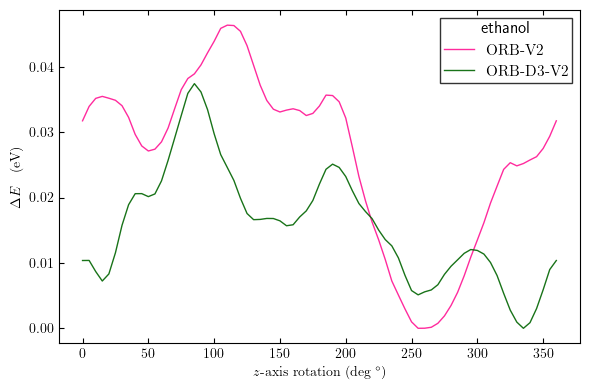

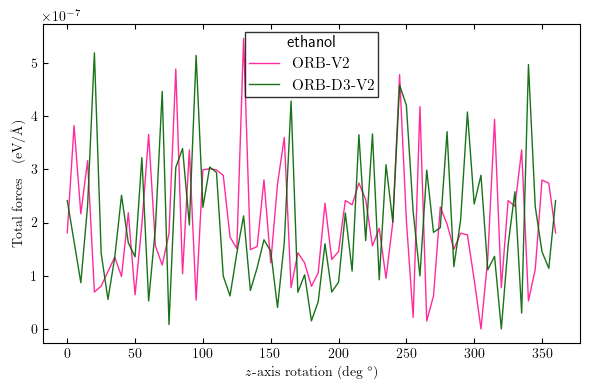

2025-02-07 23:17:18.338 python[52678:804395] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-07 23:17:18.338 python[52678:804395] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [13]:
mol_name = 'ethanol'
molecule = build.molecule('CH3CH2OH')

evaluate_rotation(molecule, calculator_list, calc_name=CALC_NAME, mol_name=mol_name)

## __FORCE TESTING__
Test whether the net force on all the atoms of a given molecule is zero (suma de forces zero). 

Test whether the net torque is zero (moment de forces zero). 

These are confitions for classical (rigid body) statics. 

In [ ]:
molecule = build.molecule('H2O')
molecule.calc = orb_calc_v2

forces = np.array(molecule.get_forces())

f_vec = forces.sum(axis=0)
f_scalar = np.sqrt(f_vec.dot(f_vec))